In [1]:
import os
import json
import shutil
import tempfile
import time

import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib

from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai import transforms
from monai.transforms import (
    AsDiscrete,
    Activations,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.utils.enums import MetricReduction
from monai.networks.nets import SwinUNETR
from monai import data
from monai.data import decollate_batch
from functools import partial

import torch


print_config()

MONAI version: 1.4.0
Numpy version: 1.24.2
Pytorch version: 2.6.0+cu124
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 46a5272196a6c2590ca2589029eed8e4d56ff008
MONAI __file__: /home/<username>/workspace/brain-tumor-segmentation/venv/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.2
scikit-image version: 0.25.1
scipy version: 1.13.1
Pillow version: 11.1.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.21.0+cu124
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 7.0.0
pandas version: 2.2.3
einops version: 0.8.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INS

Directory for storing MONAI results and re-using downloads

In [2]:
directory = 'models-monai'
root_dir = tempfile.mkdtemp() if directory is None else directory

In [3]:
import os
import json
import numpy as np
import torch

class AverageMeter:
    """
    Computes and stores the average, sum, and count of a metric.
    Useful for tracking loss, accuracy, or other evaluation metrics during training.
    """

    def __init__(self):
        """
        Initializes the AverageMeter and resets all statistics.
        """
        self.reset()

    def reset(self):
        """
        Resets the meter to initial values.
        """
        self.val = 0  # Current value
        self.avg = 0  # Average of all values
        self.sum = 0  # Sum of all values
        self.count = 0  # Number of updates

    def update(self, val, n=1):
        """
        Updates the meter with a new value.

        Args:
            val (float): The new value to add.
            n (int, optional): The number of instances (default is 1).
        """
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = np.where(self.count > 0, self.sum / self.count, self.sum)  # Avoid division by zero

def datafold_read(datalist, basedir, fold=0):
    """
    Reads a dataset split from a JSON file and maps file paths to a base directory.

    Args:
        datalist (str): Path to the dataset JSON file.
        basedir (str): Base directory where the dataset files are stored.
        fold (int, optional): The fold index for cross-validation (default is 0).

    Returns:
        tuple: Two lists containing:
            - train_files (list): List of training samples.
            - val_files (list): List of validation samples (matching the specified fold).
    """
    # Load JSON data
    with open(datalist, "r") as f:
        json_data = json.load(f)

    # Extract the fold data (assumes "folds" key exists)
    folds = json_data.get("folds", [])

    # Ensure the requested fold exists
    if fold >= len(folds):
        raise ValueError(f"Fold index {fold} out of range. Available folds: {len(folds)}")

    fold_data = folds[fold]  # Get the requested fold's train/val data

    # Initialize lists for train and validation files
    train_files = []
    val_files = []

    # Process training and validation data
    if "train" in fold_data:
        train_files = [sample for sample in fold_data["train"]]
    if "val" in fold_data:
        val_files = [sample for sample in fold_data["val"]]

    return train_files, val_files


def save_checkpoint(model, epoch, filename="model.pt", best_acc=0, dir_add="."):
    """
    Saves the model checkpoint to a file.

    Args:
        model (torch.nn.Module): The PyTorch model to save.
        epoch (int): The current epoch number.
        filename (str, optional): The filename for saving the checkpoint (default is "model.pt").
        best_acc (float, optional): The best accuracy achieved so far (default is 0).
        dir_add (str, optional): Directory to save the checkpoint file (default is the current directory).

    Returns:
        None
    """
    # Get model state dictionary
    state_dict = model.state_dict()

    # Create the checkpoint dictionary
    save_dict = {
        "epoch": epoch,
        "best_acc": best_acc,
        "state_dict": state_dict
    }

    # Construct full path and save
    filename = os.path.join(dir_add, filename)
    torch.save(save_dict, filename)
    print(f"Saving checkpoint: {filename}")

In [4]:
def get_loader(batch_size, data_dir, json_list, fold, roi):
    """
    Creates PyTorch DataLoaders for training and validation using MONAI transformations.

    Args:
        batch_size (int): The batch size for the training DataLoader.
        data_dir (str): Path to the directory containing the dataset.
        json_list (str): Path to the JSON file containing the dataset split information.
        fold (int): The fold index to use for validation (for cross-validation).
        roi (tuple or list): The region of interest (ROI) dimensions for cropping (depth, height, width).

    Returns:
        tuple: Two PyTorch DataLoaders:
            - train_loader: DataLoader for training data.
            - val_loader: DataLoader for validation data.
    """

    # Load dataset split based on fold index
    train_files, validation_files = datafold_read(datalist=json_list, basedir=data_dir, fold=fold)
    
    print(f"Total Training Samples: {len(train_files)}")
    print(f"Total Validation Samples: {len(validation_files)}")
    print("Example Training Sample:", train_files[0] if train_files else "No data")
    print("Example Validation Sample:", validation_files[0] if validation_files else "No data")

    # Define data augmentation and preprocessing transforms for training
    train_transform = transforms.Compose([
        transforms.LoadImaged(keys=["images", "label"]),  # Load images and labels
        transforms.ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),  # Convert segmentation labels to multi-channel
        transforms.CropForegroundd(
                keys=["images", "label"],
                source_key="images",
                k_divisible=(roi[0], roi[1], roi[2]),
            ),
        transforms.RandFlipd(keys=["images", "label"], prob=0.5, spatial_axis=0),  # Random flip along axis 0
        transforms.RandFlipd(keys=["images", "label"], prob=0.5, spatial_axis=1),  # Random flip along axis 1
        transforms.RandFlipd(keys=["images", "label"], prob=0.5, spatial_axis=2),  # Random flip along axis 2
        transforms.NormalizeIntensityd(keys="images", nonzero=True, channel_wise=True),  # Normalize intensity
    ])

    # Define preprocessing transforms for validation (without augmentations)
    val_transform = transforms.Compose([
        transforms.LoadImaged(keys=["images", "label"]),  # Load images and labels
        transforms.ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),  # Convert labels to multi-channel format
        transforms.NormalizeIntensityd(keys="images", nonzero=True, channel_wise=True),  # Normalize intensity
    ])

    # Create training dataset and DataLoader
    train_ds = data.Dataset(data=train_files, transform=train_transform)
    train_loader = data.DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,  # Shuffle data for training
        num_workers=8,  # Use multiple workers for faster loading
        pin_memory=True  # Optimize memory usage for GPU training
    )

    # Create validation dataset and DataLoader
    val_ds = data.Dataset(data=validation_files, transform=val_transform)
    val_loader = data.DataLoader(
        val_ds,
        batch_size=1,  # Process one sample at a time
        shuffle=False,  # No shuffling for validation
        num_workers=8,  # Use multiple workers for efficient loading
        pin_memory=True
    )

    return train_loader, val_loader


Hyperparameter Configuration - Test

In [5]:
from brain_tumor_segmentation.config import PROCESSED_DATA_DIR, DATASPLIT_DIRECTORY

# Define data related directories
data_dir = os.path.join(PROCESSED_DATA_DIR, "training_data")
json_list = os.path.join(DATASPLIT_DIRECTORY, "dataset_5-folds_strategy_2_v1.json")

# Hyperparameters
roi = (32, 32, 32)
batch_size = 1
sw_batch_size = 2
fold = 1
infer_overlap = 0.5
max_epochs = 50
val_every = 10

# Get training data loader and validation data loader
train_loader, val_loader = get_loader(batch_size, data_dir, json_list, fold, roi)

2025-02-17 09:09:38.487 | INFO     | brain_tumor_segmentation.config:<module>:11 - PROJ_ROOT path is: /home/cepa995/workspace/brain-tumor-segmentation


Total Training Samples: 442
Total Validation Samples: 111
Example Training Sample: {'subject': 'BraTS2021_new-not-previously-in-TCIA_00796', 'images': ['/home/cepa995/workspace/brain-tumor-segmentation/data/processed/training_data/BraTS2021_new-not-previously-in-TCIA_00796/BraTS2021_new-not-previously-in-TCIA_00796_t1w.nii.gz', '/home/cepa995/workspace/brain-tumor-segmentation/data/processed/training_data/BraTS2021_new-not-previously-in-TCIA_00796/BraTS2021_new-not-previously-in-TCIA_00796_t1wce.nii.gz', '/home/cepa995/workspace/brain-tumor-segmentation/data/processed/training_data/BraTS2021_new-not-previously-in-TCIA_00796/BraTS2021_new-not-previously-in-TCIA_00796_t2w.nii.gz', '/home/cepa995/workspace/brain-tumor-segmentation/data/processed/training_data/BraTS2021_new-not-previously-in-TCIA_00796/BraTS2021_new-not-previously-in-TCIA_00796_flair.nii.gz'], 'label': '/home/cepa995/workspace/brain-tumor-segmentation/data/processed/training_data/BraTS2021_new-not-previously-in-TCIA_00796/

/home/cepa995/workspace/brain-tumor-segmentation/venv/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


In [6]:
# Create a mapping of class ID to RGB value
color2id = {
    (0, 0, 0): 0,      # background pixel
    (0, 255, 255): 1,  # Yellow  
    (0, 255, 0): 2,    # Green  
    (0, 0, 255): 4,    # Red 
}

# Reverse map from id to color
id2color = {v: k for k, v in color2id.items()}

# Sample Image
img_path = os.path.join(PROCESSED_DATA_DIR, "training_data", "BraTS2021_UCSF-PDGM_00006", "BraTS2021_UCSF-PDGM_00006_flair.nii.gz")
seg_path = os.path.join(PROCESSED_DATA_DIR, "training_data", "BraTS2021_UCSF-PDGM_00006", "BraTS2021_UCSF-PDGM_00006_seg.nii.gz")

In [7]:
import cv2 

def num_to_rgb(num_arr, color_map=id2color):
    """
    Converts grayscale segmentation mask into RGB image
    by utilizing specific color2id pallete

    :param num_arr - numpy array for grayscale segmentation mask
    :param color_map - color pallete
    :returns floating point RGB segmentation mask
    """
    single_layer = np.squeeze(num_arr)
    output = np.zeros(num_arr.shape[:2] + (3,))
    for k in color_map.keys():
        output[single_layer == k] = color_map[k]
    # return a floating point array in range [0.0, 1.0]
    return np.float32(output) / 255.0
   
def convert_to_uint8(image):
    """
    Normalizes image to UINT8, because OpenCV works with specific
    data types when it comes to certain functionalities such as
    .addWeighted, etc.

    :param image - numpy array which has to be converted to UINT8
    :returns normalized numpy array with UINT8 data type
    """
    # Normalize image to range [0, 255] and convert to uint8
    image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
    return image.astype(np.uint8)

In [8]:
def get_all_slices(image_3d, is_label=False, view="axial"):
    """
    Extract all slices from a 3D medical image in a chosen view (axial, coronal, sagittal).

    Args:
        image_3d (numpy.ndarray): 3D medical image.
        view (str, optional): View to extract ("axial", "coronal", "sagittal"). Default is "axial".

    Returns:
        list: List of slices in the chosen view.
    """
    assert image_3d.ndim == 3

    if view == "axial":
        if not is_label:
            return [image_3d[:, :, i] for i in range(image_3d.shape[2])]
        label_slices = [num_to_rgb(image_3d[:, :, i]) for i in range(image_3d.shape[2])]
        label_slices = [convert_to_uint8(cv2.cvtColor(label_slice, cv2.COLOR_RGB2BGR)) for label_slice in label_slices]
        return label_slices
    elif view == "coronal":
        if not is_label:
            return [image_3d[:, i, :] for i in range(image_3d.shape[1])]
        label_slices = [num_to_rgb(image_3d[:, i, :]) for i in range(image_3d.shape[2])]
        label_slices = [convert_to_uint8(cv2.cvtColor(label_slice, cv2.COLOR_RGB2BGR)) for label_slice in label_slices]
        return label_slices
    elif view == "sagittal":
        if not is_label:
            return [image_3d[i, :, :] for i in range(image_3d.shape[0])]
        label_slices = [num_to_rgb(image_3d[i, :, :]) for i in range(image_3d.shape[2])]
        label_slices = [convert_to_uint8(cv2.cvtColor(label_slice, cv2.COLOR_RGB2BGR)) for label_slice in label_slices]
        return label_slices
    else:
        raise ValueError("Invalid view. Choose from 'axial', 'coronal', or 'sagittal'.")


In [9]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import cv2

def show_all_slices(img_path, seg_path, view='axial'):
    """
    Displays all slices of a given 3D medical image in a selected view (axial, coronal, sagittal).
    
    Args:
        img_path (str): Path to the 3D medical image (NIfTI file).
        seg_path (str, optional): Path to the segmentation file (NIfTI) for overlay. Default is None.
        view (str, optional): View to display ("axial", "coronal", or "sagittal"). Default is "axial".

    Returns:
        None
    """
    # Load MRI scan
    img = nib.load(img_path)
    img_numpy = img.get_fdata()

    # Load segmentation mask 
    seg = nib.load(seg_path)
    seg_numpy = seg.get_fdata()

    # Select slices based on view
    slices = get_all_slices(img_numpy, view=view)
    seg_slices = get_all_slices(seg_numpy, is_label=True, view=view)

    # Number of slices
    num_slices = len(slices)
    
    # Set figure size dynamically
    cols = 10  # Fixed number of columns
    rows = int(np.ceil(num_slices / cols))  # Compute rows dynamically

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    axes = axes.flatten()  # Flatten to access easily

    for i in range(num_slices):
        if i >= len(axes):  # If we have fewer slices than axes, stop
            break

        img_slice = slices[i]
        
        if seg_slices is not None:
            # Process segmentation overlay
            # alpha + beta needs to be 1 if alpha == 1, then beta is 
            # 0 and the mask is applied without any transparancy
            alpha = 0.5
            # Input images must be in BGR format, NOT RGB
            seg_slice = seg_slices[i]
            img_slice    = convert_to_uint8(img_slice)
            img_slice    = np.expand_dims(img_slice, 2)
            img_slice    = cv2.cvtColor(img_slice, cv2.COLOR_GRAY2BGR)
            img_slice    = cv2.addWeighted(img_slice, alpha, seg_slice, 1-alpha, 0)
            img_slice = cv2.addWeighted(img_slice, 0.5, seg_slice, 0.5, 0)

        axes[i].imshow(img_slice, cmap="gray" if seg_slices is None else None)
        axes[i].axis("off")
        axes[i].set_title(f"Slice {i}")

    # Hide empty subplots
    for i in range(num_slices, len(axes)):
        axes[i].axis("off")

    plt.suptitle(f"All {view.capitalize()} Slices")
    plt.tight_layout()
    plt.show()


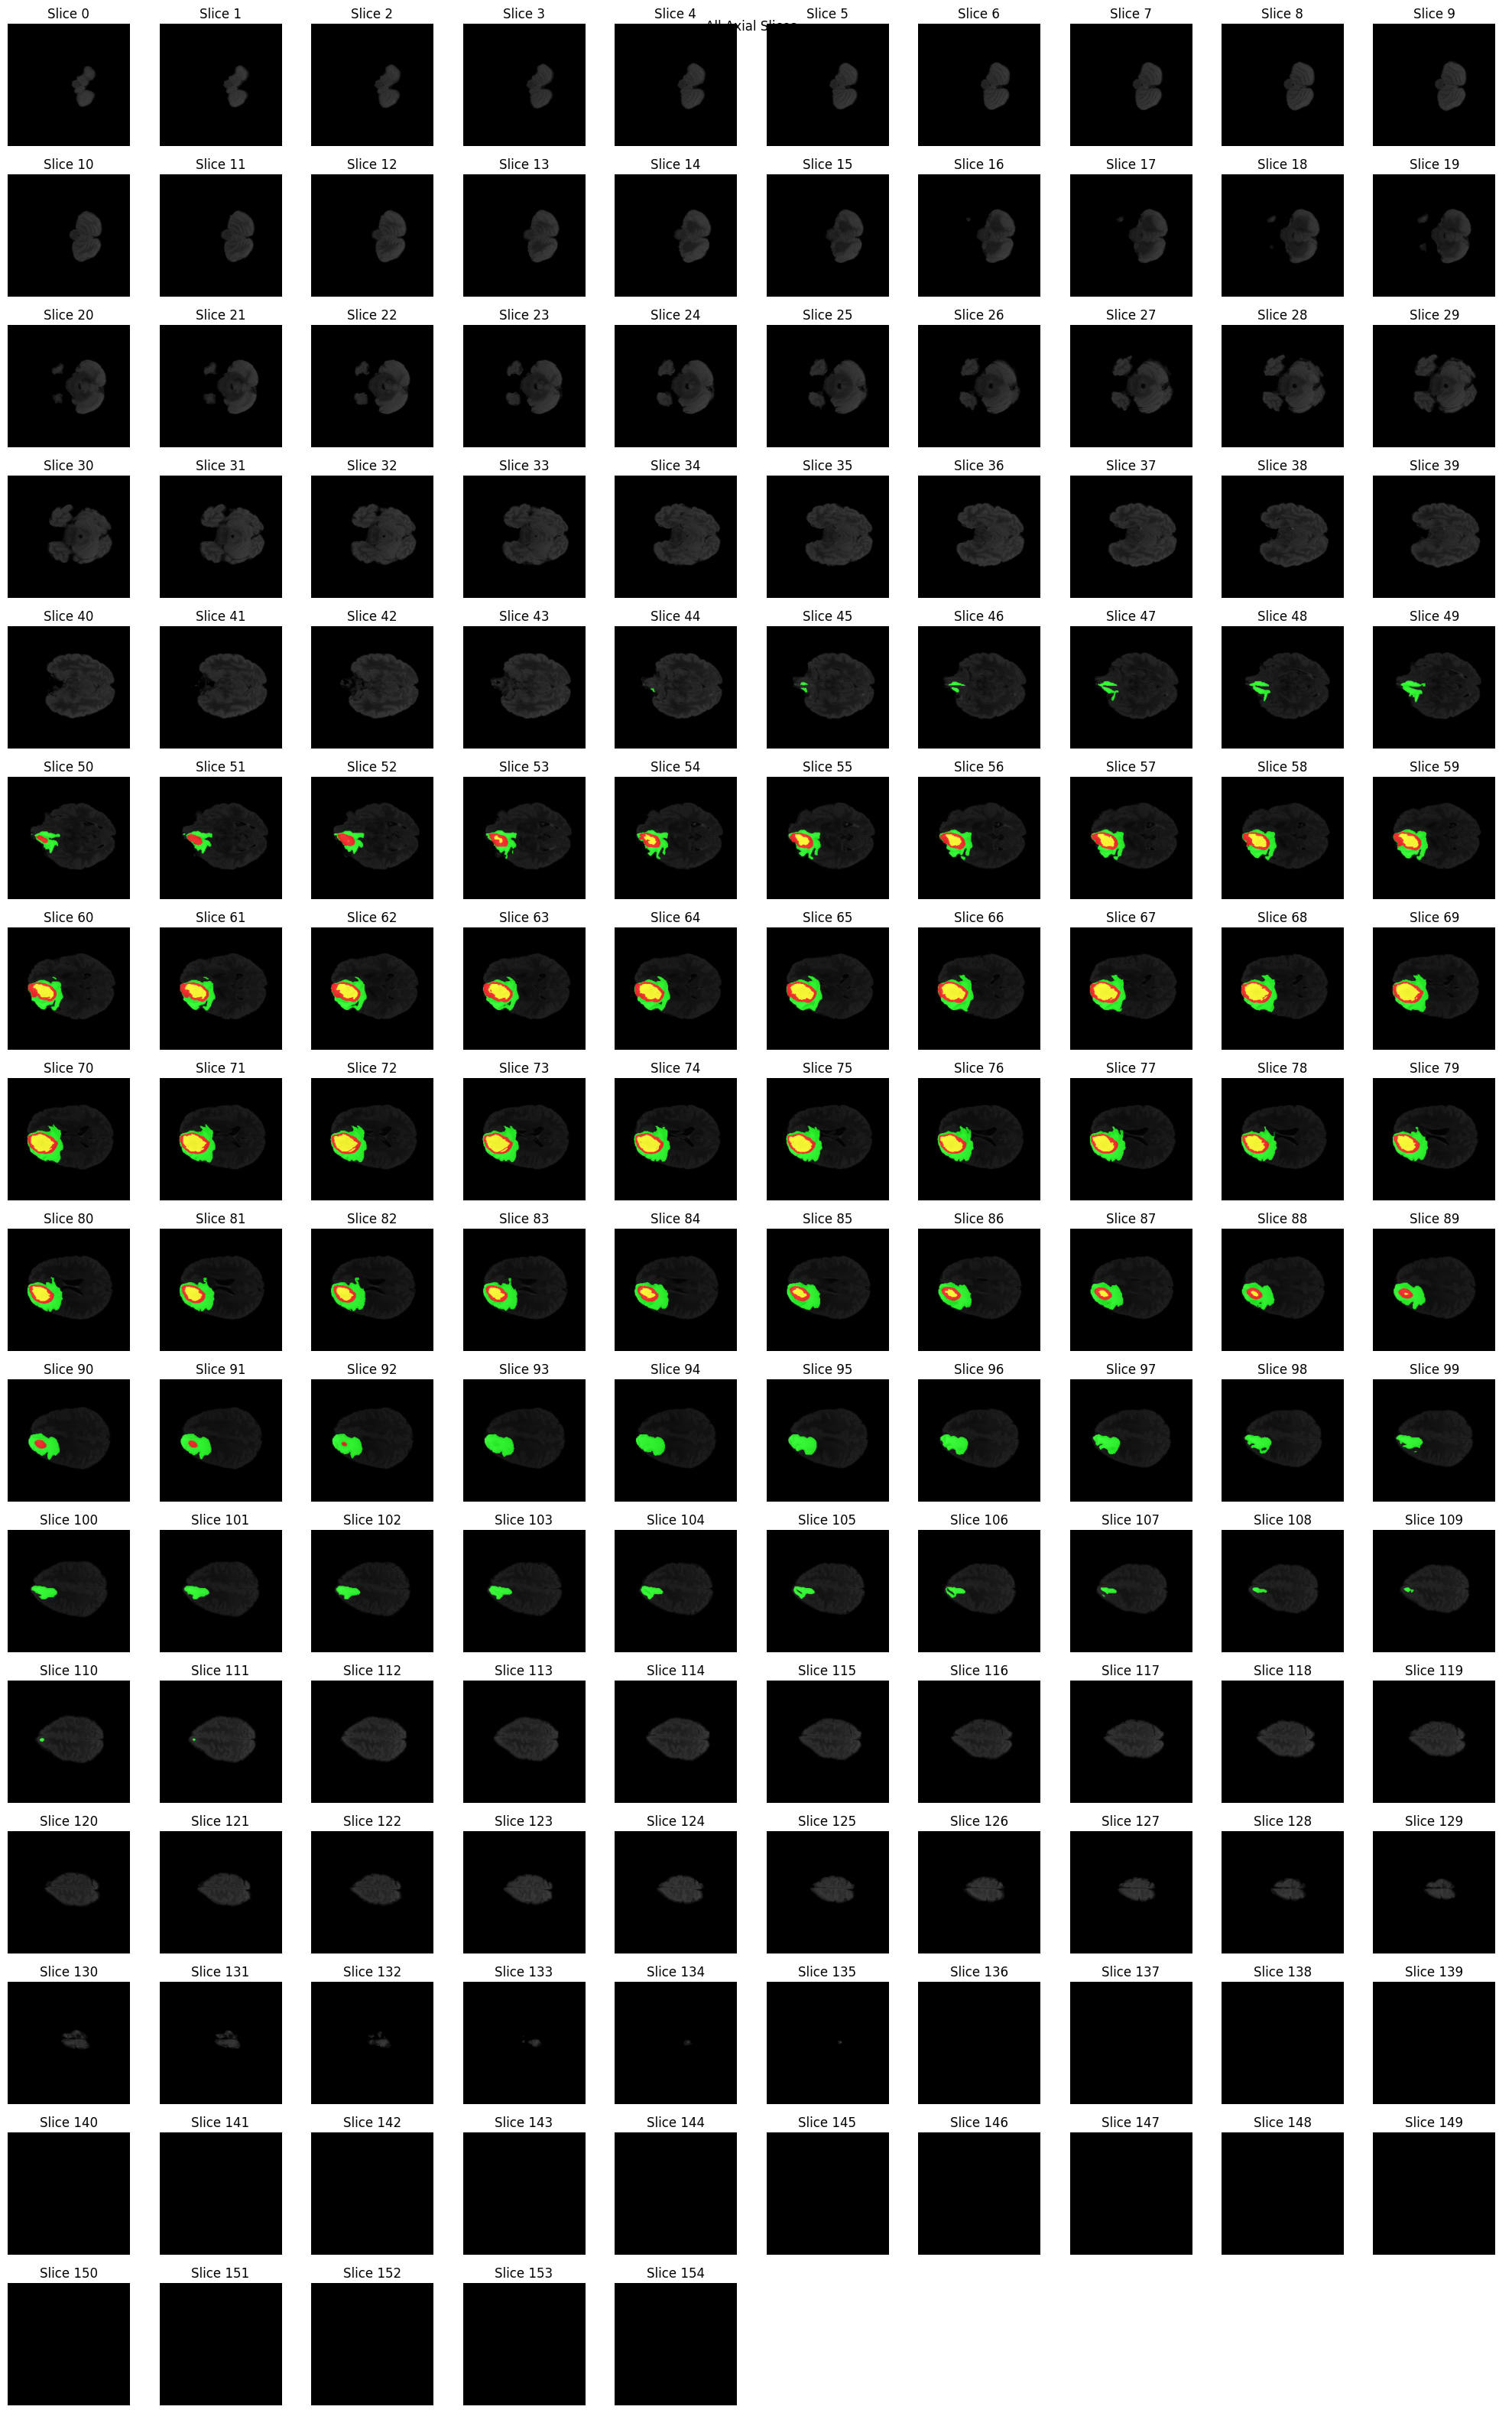

In [10]:
show_all_slices(img_path, seg_path)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SwinUNETR(
    img_size=roi,
    in_channels=4,
    out_channels=3,
    feature_size=48,
    drop_rate=0.0,
    attn_drop_rate=0.0,
    dropout_path_rate=0.0,
    use_checkpoint=True,
).to(device)

/home/cepa995/workspace/brain-tumor-segmentation/venv/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)


In [12]:
# Enable cuDNN auto-tuner for better performance (optimizes convolution operations for specific hardware)
torch.backends.cudnn.benchmark = True

# Define Dice Loss (used for segmentation tasks)
# - to_onehot_y=False: Assumes input labels are already one-hot encoded
# - sigmoid=True: Applies sigmoid activation before computing Dice Loss
dice_loss = DiceLoss(to_onehot_y=False, sigmoid=True)

# Define post-processing steps for model output
# - Applies sigmoid activation to predictions (normalizes to [0,1] range)
post_sigmoid = Activations(sigmoid=True)

# - Converts sigmoid outputs to binary segmentation masks (threshold at 0.5)
post_pred = AsDiscrete(argmax=False, threshold=0.5)

# Define Dice Metric for evaluating segmentation accuracy
# - include_background=True: Includes background in the calculation
# - reduction=MetricReduction.MEAN_BATCH: Computes mean Dice score across batch
# - get_not_nans=True: Ensures NaN values are excluded from the calculation
dice_acc = DiceMetric(include_background=True, reduction=MetricReduction.MEAN_BATCH, get_not_nans=True)

# Define the model inferer for sliding window inference
# - This is useful for handling large 3D images by breaking them into smaller overlapping patches
model_inferer = partial(
    sliding_window_inference,
    roi_size=[roi[0], roi[1], roi[2]],  # Size of sliding window region (e.g., 128x128x128)
    sw_batch_size=sw_batch_size,  # Number of sub-patches processed at once
    predictor=model,  # The trained model used for inference
    overlap=infer_overlap,  # Defines overlap between sliding windows (e.g., 0.25 means 25% overlap)
)

# Define optimizer (AdamW) for training the model
# - lr=1e-4: Initial learning rate
# - weight_decay=1e-5: Regularization parameter to prevent overfitting
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

# Define learning rate scheduler (Cosine Annealing)
# - T_max=max_epochs: Number of epochs before restarting the learning rate cycle
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

In [13]:
def train_epoch(model, loader, optimizer, epoch, loss_func):
    """
    Trains the model for one epoch.

    Args:
        model (torch.nn.Module): The model to train.
        loader (torch.utils.data.DataLoader): The DataLoader providing training data.
        optimizer (torch.optim.Optimizer): The optimizer used for training.
        epoch (int): The current epoch number.
        loss_func (callable): The loss function to optimize.

    Returns:
        float: The average loss for the epoch.
    """
    model.train()  # Set model to training mode
    start_time = time.time()
    run_loss = AverageMeter()  # Tracks running loss

    for idx, batch_data in enumerate(loader):
        # Move data to the appropriate device (GPU/CPU)
        data, target = batch_data["images"].to(device), batch_data["label"].to(device)

        # Forward pass
        logits = model(data)

        # Compute loss
        loss = loss_func(logits, target)

        # Backward pass & optimizer step
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()  # Reset gradients after step

        # Update running loss
        run_loss.update(loss.item(), n=batch_size)

        # Print training status
        print(
            f"Epoch {epoch}/{max_epochs} | Batch {idx}/{len(loader)} | "
            f"Loss: {run_loss.avg:.4f} | Time: {time.time() - start_time:.2f}s"
        )

        start_time = time.time()  # Reset time for next iteration

    return run_loss.avg  # Return average loss for the epoch


def val_epoch(
    model,
    loader,
    epoch,
    acc_func,
    model_inferer=None,
    post_sigmoid=None,
    post_pred=None,
):
    """
    Evaluates the model on the validation dataset.

    Args:
        model (torch.nn.Module): The model to evaluate.
        loader (torch.utils.data.DataLoader): The DataLoader providing validation data.
        epoch (int): The current epoch number.
        acc_func (monai.metrics.DiceMetric): The Dice accuracy metric.
        model_inferer (callable, optional): Function for performing inference (e.g., sliding window inference).
        post_sigmoid (callable, optional): Activation function applied after model output (e.g., sigmoid).
        post_pred (callable, optional): Discretization function to convert predictions into binary masks.

    Returns:
        list: The average Dice scores for each tumor region.
    """
    model.eval()  # Set model to evaluation mode
    start_time = time.time()
    run_acc = AverageMeter()  # Tracks running Dice score

    with torch.no_grad():  # Disable gradient computation
        for idx, batch_data in enumerate(loader):
            # Move data to device (GPU/CPU)
            data, target = batch_data["images"].to(device), batch_data["label"].to(device)

            # Perform inference
            logits = model_inferer(data)

            # Decollate batch (split batched tensors into a list of individual tensors)
            val_labels_list = decollate_batch(target)
            val_outputs_list = decollate_batch(logits)

            # Post-processing: Apply sigmoid and thresholding to predictions
            val_output_convert = [
                post_pred(post_sigmoid(val_pred_tensor)) for val_pred_tensor in val_outputs_list
            ]

            # Compute Dice metric
            acc_func.reset()
            acc_func(y_pred=val_output_convert, y=val_labels_list)
            acc, not_nans = acc_func.aggregate()  # Compute mean Dice score, ignoring NaNs

            # Update running accuracy
            run_acc.update(acc.cpu().numpy(), n=not_nans.cpu().numpy())

            # Extract Dice scores for different tumor regions
            dice_tc = run_acc.avg[0]  # Tumor core
            dice_wt = run_acc.avg[1]  # Whole tumor
            dice_et = run_acc.avg[2]  # Enhancing tumor

            # Print validation status
            print(
                f"Validation {epoch}/{max_epochs} | Batch {idx}/{len(loader)} | "
                f"Dice_TC: {dice_tc:.4f}, Dice_WT: {dice_wt:.4f}, Dice_ET: {dice_et:.4f} | "
                f"Time: {time.time() - start_time:.2f}s"
            )

            start_time = time.time()  # Reset time for next iteration

    return run_acc.avg  # Return average Dice scores for the epoch


In [ ]:
def trainer(
    model,
    train_loader,
    val_loader,
    optimizer,
    loss_func,
    acc_func,
    scheduler,
    model_inferer=None,
    start_epoch=0,
    post_sigmoid=None,
    post_pred=None,
):
    """
    Trains and validates the model over multiple epochs.

    Args:
        model (torch.nn.Module): The neural network model to train.
        train_loader (torch.utils.data.DataLoader): DataLoader for training data.
        val_loader (torch.utils.data.DataLoader): DataLoader for validation data.
        optimizer (torch.optim.Optimizer): Optimizer for updating model weights.
        loss_func (callable): Loss function used for training.
        acc_func (monai.metrics.DiceMetric): Dice metric for validation accuracy.
        scheduler (torch.optim.lr_scheduler): Learning rate scheduler.
        model_inferer (callable, optional): Function for performing inference (e.g., sliding window inference).
        start_epoch (int, optional): The starting epoch for resuming training. Default is 0.
        post_sigmoid (callable, optional): Activation function applied after model output (e.g., sigmoid).
        post_pred (callable, optional): Discretization function to convert predictions into binary masks.

    Returns:
        tuple: Contains training statistics:
            - val_acc_max (float): Best validation accuracy achieved.
            - dices_tc (list): List of Dice scores for the Tumor Core (TC) over epochs.
            - dices_wt (list): List of Dice scores for the Whole Tumor (WT) over epochs.
            - dices_et (list): List of Dice scores for the Enhancing Tumor (ET) over epochs.
            - dices_avg (list): List of average Dice scores over epochs.
            - loss_epochs (list): List of training loss values over epochs.
            - trains_epoch (list): List of epoch indices for tracking progress.
    """
    val_acc_max = 0.0  # Track the highest validation accuracy
    dices_tc, dices_wt, dices_et, dices_avg = [], [], [], []
    loss_epochs, trains_epoch = [], []

    # Loop over the number of epochs
    for epoch in range(start_epoch, max_epochs):
        print(time.ctime(), f"Epoch: {epoch}")
        epoch_time = time.time()

        # Train for one epoch
        train_loss = train_epoch(
            model, train_loader, optimizer, epoch=epoch, loss_func=loss_func
        )

        # Print training status
        print(
            f"Final training {epoch}/{max_epochs - 1} | "
            f"Loss: {train_loss:.4f} | "
            f"Time: {time.time() - epoch_time:.2f}s"
        )

        # Perform validation at specified intervals
        if (epoch + 1) % val_every == 0 or epoch == 0:
            loss_epochs.append(train_loss)  # Store training loss
            trains_epoch.append(epoch)  # Store epoch number

            epoch_time = time.time()

            # Validate the model
            val_acc = val_epoch(
                model,
                val_loader,
                epoch=epoch,
                acc_func=acc_func,
                model_inferer=model_inferer,
                post_sigmoid=post_sigmoid,
                post_pred=post_pred,
            )

            # Extract Dice scores
            dice_tc, dice_wt, dice_et = val_acc[0], val_acc[1], val_acc[2]
            val_avg_acc = np.mean(val_acc)  # Compute average Dice score

            # Print validation results
            print(
                f"Final validation stats {epoch}/{max_epochs - 1} | "
                f"Dice_TC: {dice_tc:.4f}, Dice_WT: {dice_wt:.4f}, Dice_ET: {dice_et:.4f}, "
                f"Dice_Avg: {val_avg_acc:.4f} | "
                f"Time: {time.time() - epoch_time:.2f}s"
            )

            # Store validation scores
            dices_tc.append(dice_tc)
            dices_wt.append(dice_wt)
            dices_et.append(dice_et)
            dices_avg.append(val_avg_acc)

            # Save model checkpoint if new best validation accuracy is achieved
            if val_avg_acc > val_acc_max:
                print(f"New best accuracy ({val_acc_max:.6f} → {val_avg_acc:.6f}). Saving model...")
                val_acc_max = val_avg_acc
                save_checkpoint(model, epoch, best_acc=val_acc_max)

            # Update learning rate
            scheduler.step()

    print("Training Finished! Best Accuracy:", val_acc_max)

    return val_acc_max, dices_tc, dices_wt, dices_et, dices_avg, loss_epochs, trains_epoch


: 

In [ ]:
train = True
if train:
    # Initialize training from the first epoch
    start_epoch = 0  

    # Run the training process and store results
    (
        val_acc_max,   
        dices_tc,      # Dice scores for Tumor Core (TC) over epochs
        dices_wt,      # Dice scores for Whole Tumor (WT) over epochs
        dices_et,      # Dice scores for Enhancing Tumor (ET) over epochs
        dices_avg,    
        loss_epochs,   
        trains_epoch,  
    ) = trainer(
        model=model,                   
        train_loader=train_loader,      
        val_loader=val_loader,          
        optimizer=optimizer,            
        loss_func=dice_loss,            
        acc_func=dice_acc,              
        scheduler=scheduler,            
        model_inferer=model_inferer,  
        start_epoch=start_epoch,      
        post_sigmoid=post_sigmoid,    
        post_pred=post_pred,           
    )

    # Print summary after training
    print(f"\nTraining complete! Best Validation Accuracy: {val_acc_max:.4f}")

Mon Feb 17 09:09:46 2025 Epoch: 0
